In [46]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  
from GPyOpt.methods import BayesianOptimization

Neural Network Model for Hyper Parameter Tuning

In [47]:
def benchmark(X, Y):
    return -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)


In [48]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [49]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [50]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 5, 5)
Y = np.random.uniform(-5, 5, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [51]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [52]:
df

,x,y,z
0,-0.829780,-4.076614,-284.253932
1,2.203245,-3.137398,-111.669530
2,-4.998856,-1.544393,-247.301416
3,-1.976674,-1.032325,-128.722651
4,-3.532441,0.388167,-111.174208


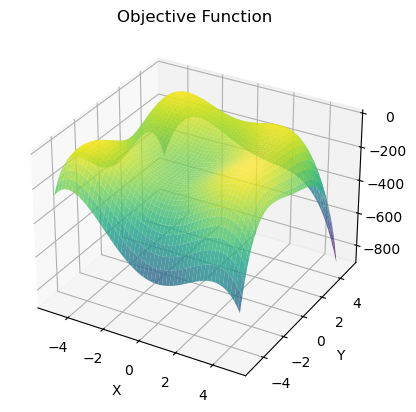

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Objective Function')

# Show the plot
plt.show()

In [54]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [55]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 3, "Y":  2, "Z": benchmark(0,  0)},
    {"X": -2.805, "Y":  3.131, "Z": benchmark(0,  0)},
    {"X": -3.779, "Y":  -3.283, "Z": benchmark(0,  0)},
    {"X": 3.584, "Y":  -1.848, "Z": benchmark(0,  0)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

,X,Y,Z
0,3.000,2.000,-170
1,-2.805,3.131,-170
2,-3.779,-3.283,-170
3,3.584,-1.848,-170


In [56]:
def perform_iteration(df):

    def sim_all(x):
        df["a"] = x[0,0]
        df["b"] = x[0,1]
        df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
        df["diff"] = df["z"] - df["sim_z"]
        return (df["diff"]**2).sum()

    bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
            {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

    # Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
    bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
    bo.run_optimization(max_iter=max_bo_iter)
    df["a"] = bo.x_opt[0]
    df["b"] = bo.x_opt[1]
    print(bo.x_opt)

    # Create the grid of input values
    x_range = np.linspace(-5, 5, 100)
    y_range = np.linspace(-5, 5, 100)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

    # Create the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors')

    # Show the plot
    plt.show()

    # Generate 15 points using Latin Hypercube Sampling (LHS)
    n_samples = 75
    lhs= qmc.LatinHypercube(d=2, optimization="random-cd")
    lhs_samples = lhs.random(n=n_samples)
    bounds = np.array([[-5, 5], [-5, 5]])  # Bounds for Design Space

    scaled_samples = qmc.scale(lhs_samples, bounds[:, 0], bounds[:, 1])

    selected_points_df = pd.DataFrame(scaled_samples, columns=['x', 'y'])
    selected_points_df['sim_z'] = sim_eval(selected_points_df['x'], selected_points_df['y'], bo.x_opt[0], bo.x_opt[1])

    sim_df = df[["x", "y", "sim_z"]]
    sim_df = pd.concat([sim_df, selected_points_df], axis=0, ignore_index=True)
    
    # # Define the objective function to minimize
    # @use_named_args(hyp_space)
    # def objective(**params):
    #     num_layers = params['num_layers']
    #     num_units = params['num_units']
    #     learning_rate = params['learning_rate']
    #     dropout_rate = params['dropout_rate']
    #     batch_size = params['batch_size']
    #     epochs = params['epochs']

    #     model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
    #     # Define K-fold cross-validation
    #     kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    #     scores = []

    #     # Perform cross-validation
    #     for train_idx, val_idx in kfold.split(df[['x', 'y']]):
    #         X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
    #         y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

    #         # Standardize the features
    #         scaler_x = StandardScaler().fit(X_train)
    #         X_train_scaled = scaler_x.transform(X_train)
    #         X_val_scaled = scaler_x.transform(X_val)

    #         # Train the model
    #         model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

    #         # Evaluate the model
    #         score = model.evaluate(X_val_scaled, y_val, verbose=0)
    #         scores.append(score)
    
    #     return np.mean(scores)

    # # Perform Bayesian optimization
    # result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # # Output best hyperparameters from BayesOpt
    # print("Best hyperparameters:")
    # print("num_layers:", result.x[0])
    # print("num_units:", result.x[1])
    # print("learning_rate:", result.x[2])
    # print("dropout_rate:", result.x[3])
    # print("batch_size:", result.x[4])
    # print("epochs:", result.x[5])

    # # Train the model with the best hyperparameters on the entire dataset
    # best_model = NN_model(
    #     num_layers=result.x[0],
    #     num_units=result.x[1],
    #     learning_rate=result.x[2],
    #     dropout_rate=result.x[3]
    # )

    # # Standardize the Dataset of Simulation Responses
    # scaler_x = StandardScaler().fit(sim_df[['x', 'y']])
    # X_scaled = scaler_x.transform(sim_df[['x', 'y']])

    # # Train the best model on the combined standardized dataset
    # best_model.fit(X_scaled, sim_df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    
    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=6,
        num_units=300,
        learning_rate=0.01,
        dropout_rate=0.2
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(sim_df[['x', 'y']])
    X_scaled = scaler_x.transform(sim_df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, sim_df[['sim_z']], epochs=500, batch_size=128, verbose=1)

    # Create a meshgrid and combine into a single array
    xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    pred_mean, pred_std = mc_dropout_predictions(best_model, xy_grid)

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x_grid.shape)

    mean_surface = ax.plot_surface(x_grid, y_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x_grid, y_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x_grid, y_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Customize the plot
    ax.set_title('Neural Network of Simulated Response with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()
    
    x_range = [(-5, 5)]
    y_range = [(-5, 5)]
    def p_nn(xy):
        xy = np.array(xy).reshape(1, -1)  # Ensure correct shape (1,2)
        pred_mean, pred_std = mc_dropout_predictions(best_model, xy)  # Get mean & uncertainty
        # Check if the point is inside the valid domain
        if (x_range[0][0] <= xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= xy[0, 1] <= y_range[0][1]):
            
            probability = max(pred_mean + 1.96 * pred_std - sim_df["sim_z"].median(), 1e-6)  # Avoid zero
            return probability
        else:
            return 1e-10  # Keep very small but nonzero probability for out-of-bounds case


    def metropolis_step(xy, sig):
        prop_xy = xy + np.random.normal(0, sig, size=xy.shape)  # Generate a candidate

        # Ensure proposed point is inside the valid bounds
        if not (x_range[0][0] <= prop_xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= prop_xy[0, 1] <= y_range[0][1]):
            return xy  # Reject out-of-bounds proposals

        u = np.random.uniform(0, 1)
        if u < min(1.0, p_nn(prop_xy) / p_nn(xy)):
            return prop_xy  # Accept move
        else:
            return xy  # Stay at current point


    def mh_sampler(sig, sample_size, burn_in, lag, min_distance=0.5):
        # Start at the point with the largest simulated response
        max_idx = np.argmax(sim_df["sim_z"])
        x_init = sim_df["x"].iloc[max_idx]
        y_init = sim_df["y"].iloc[max_idx]
        xy = np.array([[x_init, y_init]])
        existing_points = np.array(df[['x', 'y']])

        def is_too_close(new_point, existing_points, min_distance):
            distances = np.sqrt(np.sum((existing_points - new_point) ** 2, axis=1))
            return np.any(distances < min_distance)

        for i in range(burn_in):
            xy = metropolis_step(xy, sig)

        output = xy
        while len(output) < sample_size:
            for j in range(lag):
                xy = metropolis_step(xy, sig)

            if not is_too_close(xy, existing_points, min_distance):
                output = np.vstack((output, xy))
                existing_points = np.vstack((existing_points, xy))  # Update the existing points array

        return output

    # Use Metropolis-Hastings to sample new experimental points
    X_mh = mh_sampler(sig=8, sample_size=5, burn_in=50, lag=20)

    # Convert MH samples to a DataFrame
    physical_test_points = pd.DataFrame(X_mh, columns=["x", "y"])

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x_grid, y_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Overlay sampled points
    plt.scatter(sim_df['x'], sim_df['y'], color='white', edgecolor='black', label='Simulation Sampled Points')
    plt.scatter(physical_test_points['x'], physical_test_points['y'], color='purple', edgecolor='black', label='Next Physical Test Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    physical_test_points["z"] = benchmark(physical_test_points['x'], physical_test_points['y']) + ran_err(5, 0.05)
    physical_test_points["a"] = bo.x_opt[0]
    physical_test_points["b"] = bo.x_opt[1]
    physical_test_points["sim_z"] = sim_eval(physical_test_points["x"], physical_test_points["y"], physical_test_points["a"], physical_test_points["b"])
    physical_test_points["diff"] = physical_test_points["z"] - physical_test_points["sim_z"]

    # Heatmap of Simulated Points 
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the heatmap for sim_z_grid
    heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

    # Overlay scatter points for sampling points
    ax.scatter(df["x"], df["y"], color='blue', marker='o', label='Previous Sampled Points')
    ax.scatter(sim_df["x"], sim_df["y"], edgecolor='black', facecolors='none', marker='o', label='Sampled Simulation Points')
    ax.scatter(physical_test_points["x"], physical_test_points["y"], color='purple', marker='o', label='Next Physical Test Points')

    # Overlay scatter points for global maxima
    ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
    ax.legend()

    # Add a color bar
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Function Value (Z)')

    # Show the plot
    plt.show()

    # Add points to original dataframe
    df = pd.concat([df, physical_test_points], axis=0, ignore_index=True)

    return df

[ 4.32432971 -3.06924425]


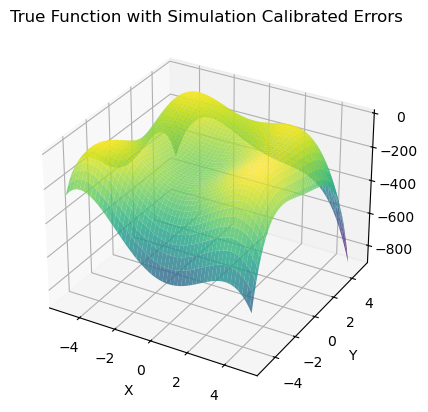

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 31105.7188
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 28283.2148
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 11731.0400
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18470.2598
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 12897.9062
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 37990.1562
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 12557.3604
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 20804.3105
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 23984.1191
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 24501.2578
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 22970.9062
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 21120.2520
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 19435.3633
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 22194.0840
Epoch 15/500
1/1 ━━━━━━━━━━━━━━

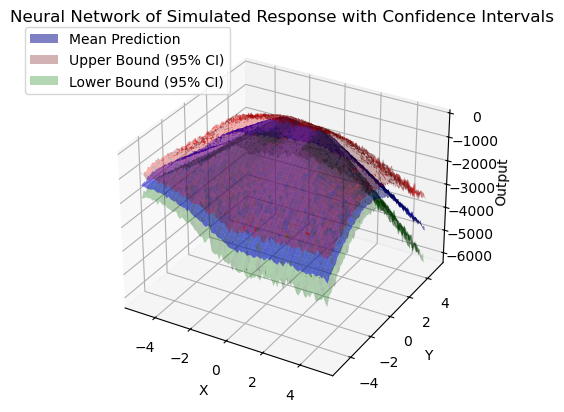

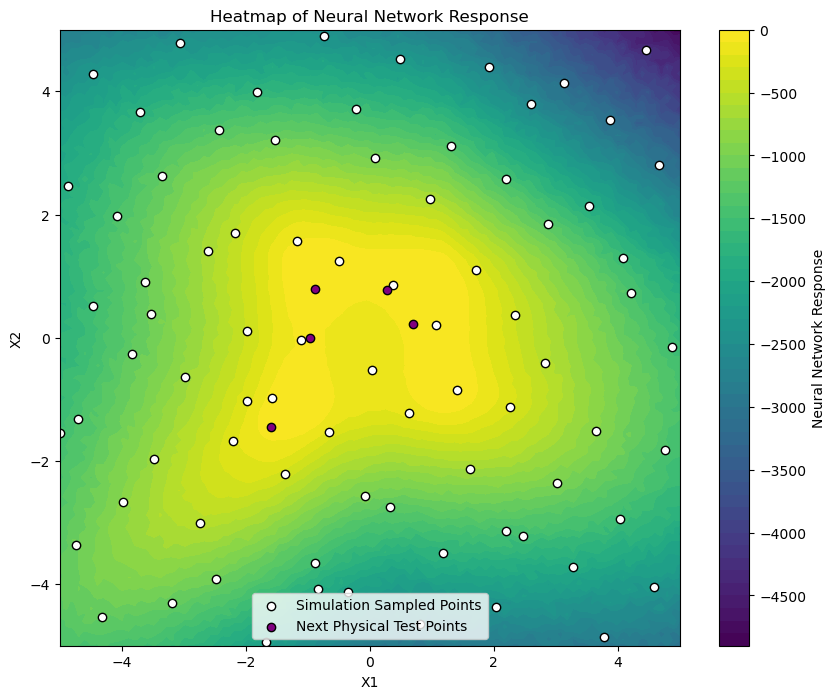

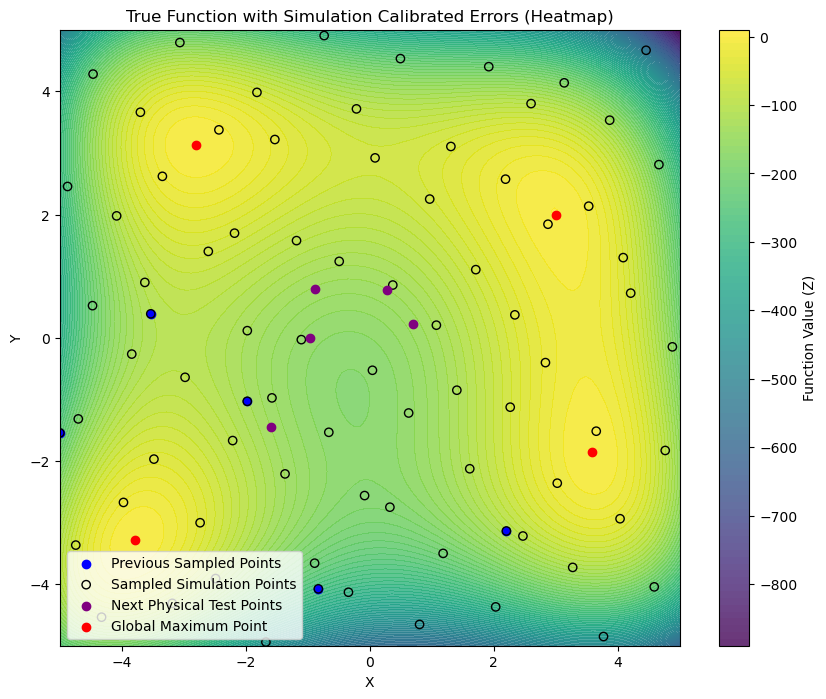

          x         y           z        a         b       sim_z      diff
0 -0.829780 -4.076614 -284.253932  4.32433 -3.069244 -282.256649 -1.997283
1  2.203245 -3.137398 -111.669530  4.32433 -3.069244 -113.354470  1.684940
2 -4.998856 -1.544393 -247.301416  4.32433 -3.069244 -242.011988 -5.289428
3 -1.976674 -1.032325 -128.722651  4.32433 -3.069244 -126.540507 -2.182144
4 -3.532441  0.388167 -111.174208  4.32433 -3.069244 -107.847611 -3.326597
5 -0.972076 -0.007623 -164.820611  4.32433 -3.069244 -164.823161  0.002550
6  0.282451  0.776517 -140.388781  4.32433 -3.069244 -140.250069 -0.138712
7 -0.875998  0.794847 -141.512763  4.32433 -3.069244 -141.582887  0.070124
8  0.689247  0.222182 -145.363744  4.32433 -3.069244 -145.306017 -0.057727
9 -1.587739 -1.445021 -140.745930  4.32433 -3.069244 -140.704292 -0.041638


In [57]:
df = perform_iteration(df)
print(df)


[ 4.41915022 -3.02419598]


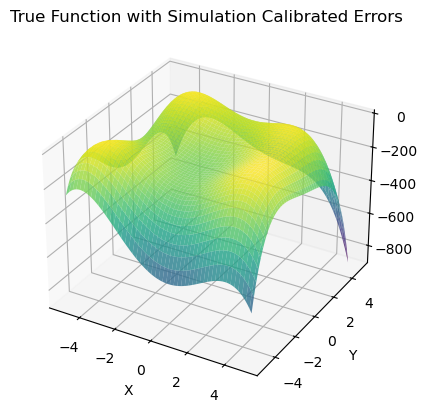

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 30790.0684
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 28568.2539
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 10272.3857
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 33911.0078
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 18151.9707
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 27280.5352
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 29393.0879
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 29991.8008
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 30145.8184
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 30047.3711
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 29795.3730
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 29474.2344
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 28440.6582
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 27090.3320
Epoch 15/500
1/1 ━━━━━━━━━━━━━━

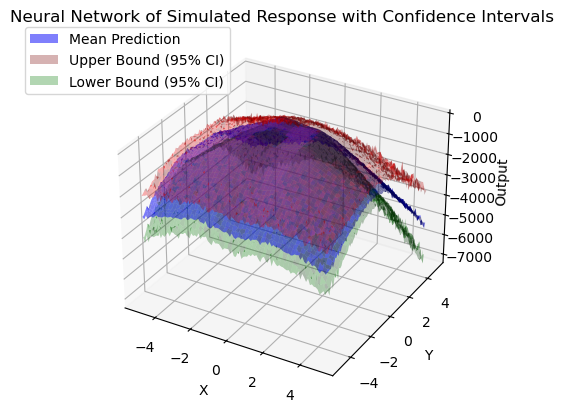

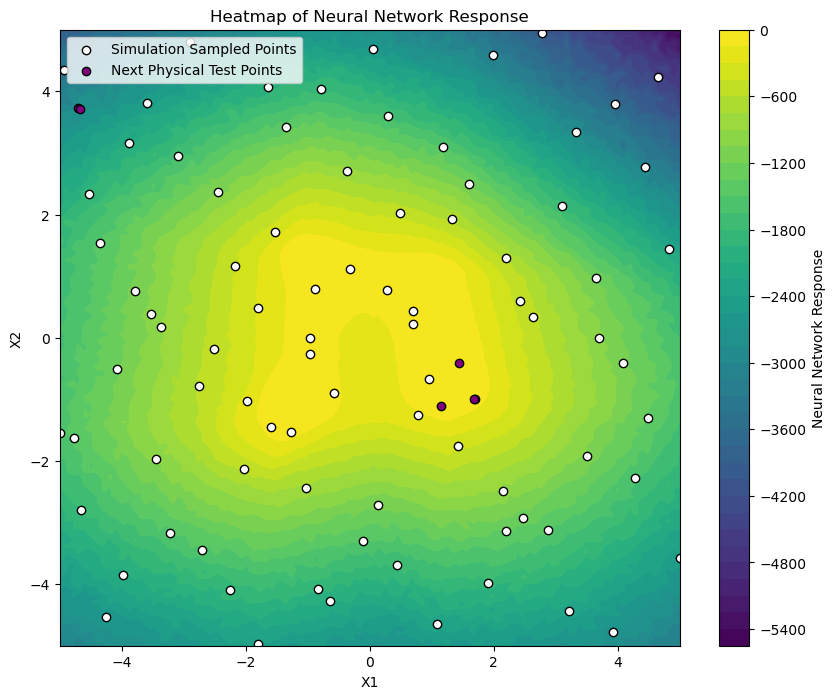

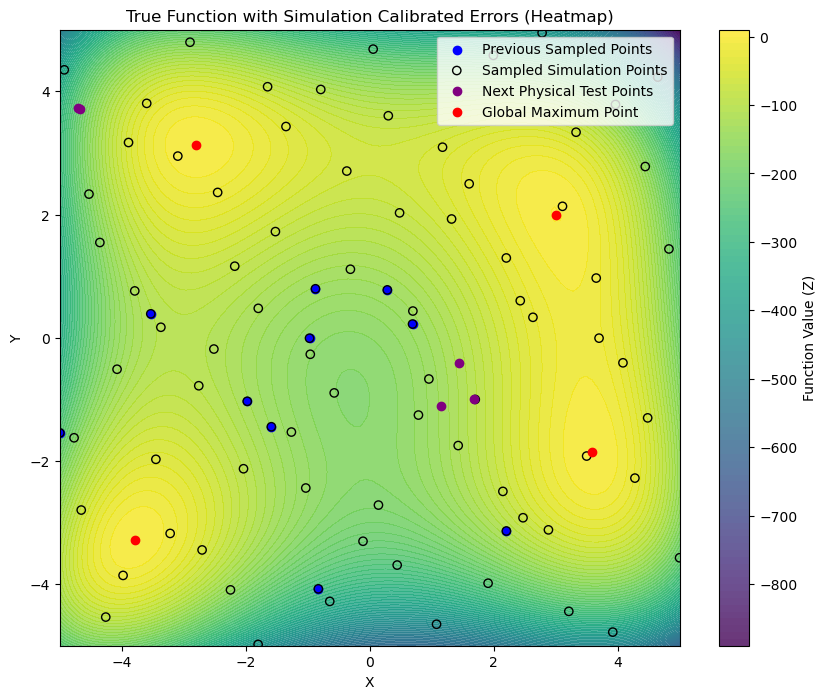

In [58]:
df = perform_iteration(df)

[ 3.90593951 -2.68584769]


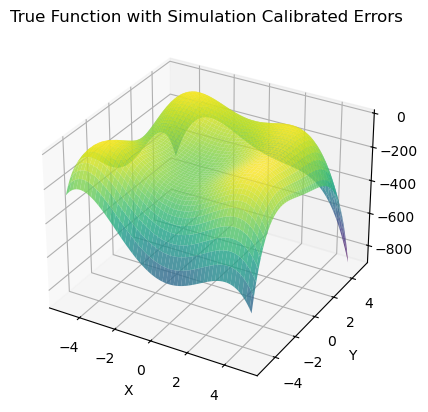

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 30188.0273
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 28044.2188
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 10236.4736
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 12116.3164
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 42598.1250
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 14282.4053
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 23340.2090
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26405.1074
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 27080.1074
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26639.3926
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 25123.9062
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 22078.3398
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 19867.0039
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 22555.5605
Epoch 15/500
1/1 ━━━━━━━━━━━━━━

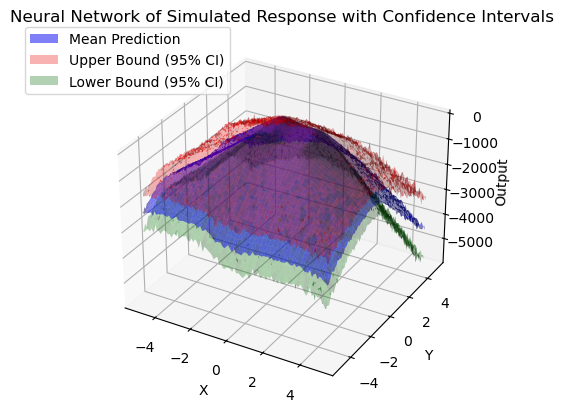

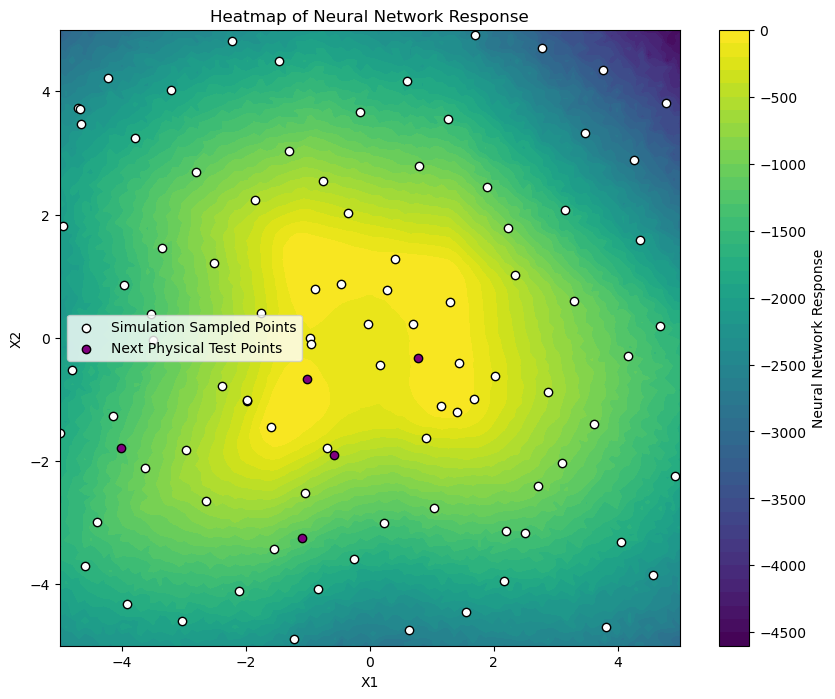

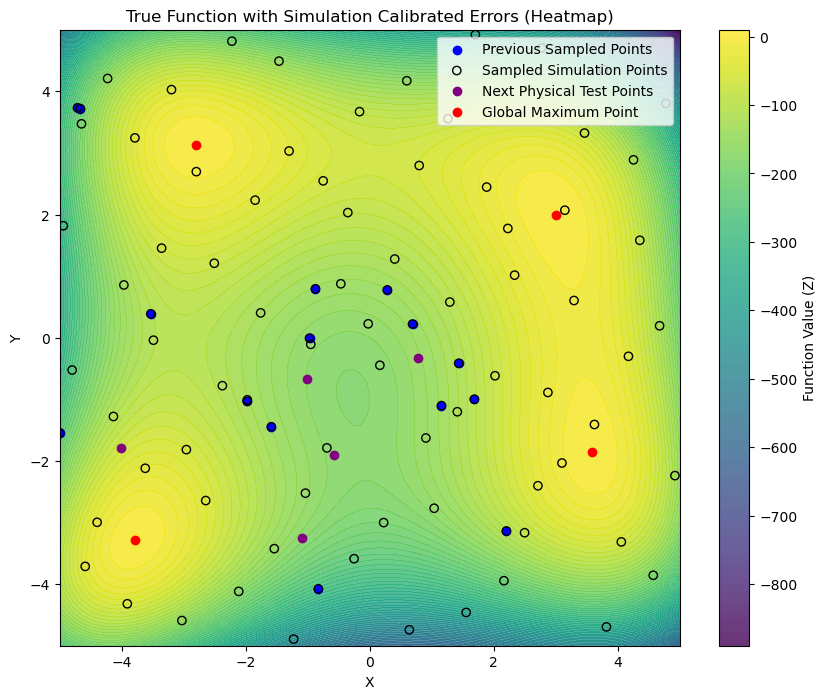

           x         y           z        a         b       sim_z      diff
0  -0.829780 -4.076614 -284.253932  3.90594 -2.685848 -283.548702 -0.705230
1   2.203245 -3.137398 -111.669530  3.90594 -2.685848 -111.495280 -0.174250
2  -4.998856 -1.544393 -247.301416  3.90594 -2.685848 -246.938795 -0.362621
3  -1.976674 -1.032325 -128.722651  3.90594 -2.685848 -128.488079 -0.234571
4  -3.532441  0.388167 -111.174208  3.90594 -2.685848 -111.281663  0.107455
5  -0.972076 -0.007623 -164.820611  3.90594 -2.685848 -164.801783 -0.018828
6   0.282451  0.776517 -140.388781  3.90594 -2.685848 -140.249935 -0.138846
7  -0.875998  0.794847 -141.512763  3.90594 -2.685848 -141.539795  0.027032
8   0.689247  0.222182 -145.363744  3.90594 -2.685848 -145.342632 -0.021112
9  -1.587739 -1.445021 -140.745930  3.90594 -2.685848 -140.577463 -0.168467
10 -4.713852  3.733259 -228.610101  3.90594 -2.685848 -228.553392 -0.056709
11 -4.667136  3.718428 -214.870733  3.90594 -2.685848 -214.925776  0.055043
12  1.433854

In [59]:
df = perform_iteration(df)
print(df)

[ 4.03987398 -2.64051695]


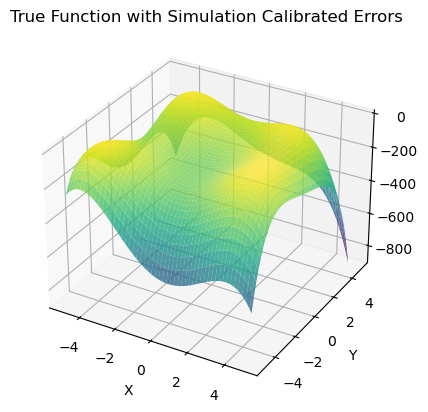

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 29436.4375
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 27251.2559
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 9138.5166
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 199107.7969
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 10471.2227
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 23885.0020
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 28052.1992
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 28984.5352
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 29200.9824
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 29244.7051
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 29214.8535
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 29139.1875
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 28993.8008
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 28769.4551
Epoch 15/500
1/1 ━━━━━━━━━━━━━━

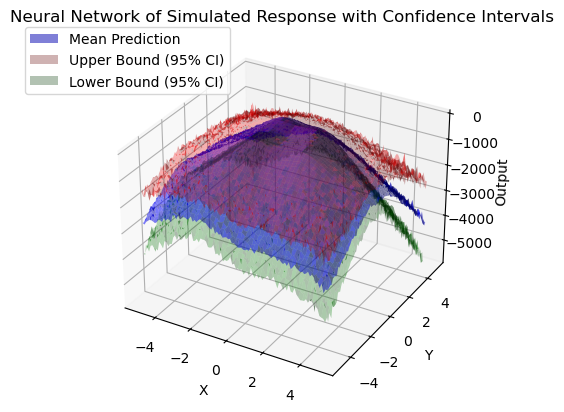

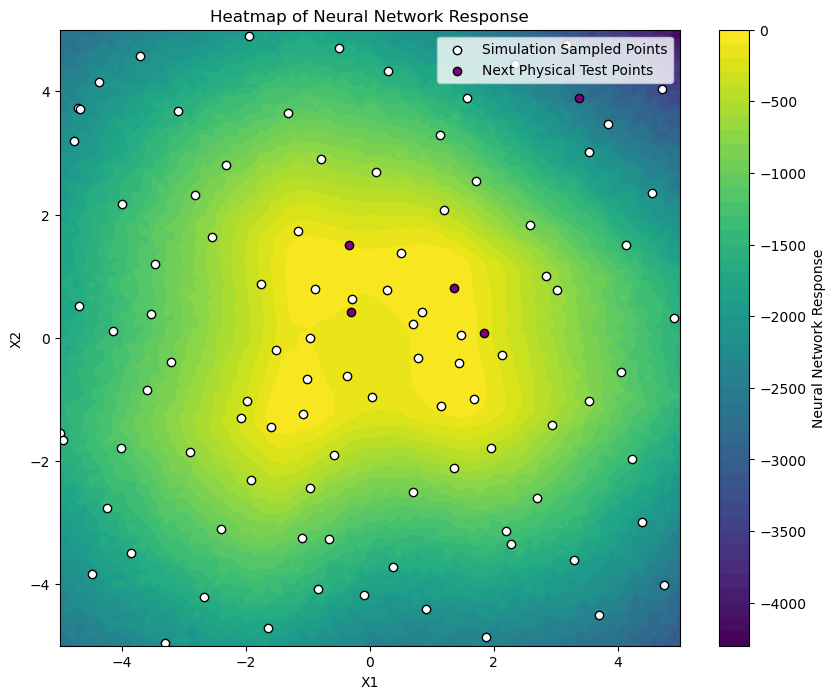

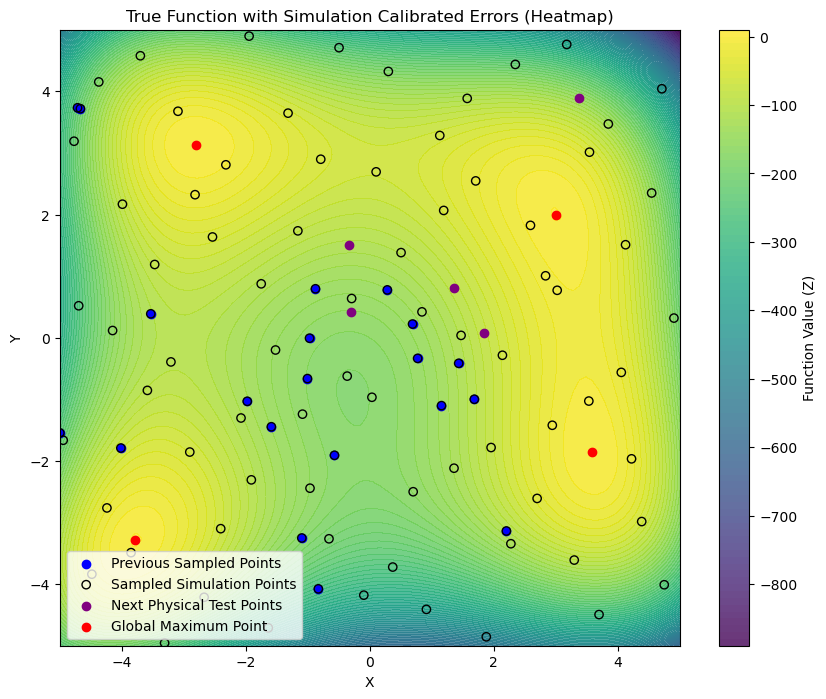

           x         y           z         a         b       sim_z      diff
0  -0.829780 -4.076614 -284.253932  4.039874 -2.640517 -283.886684 -0.367249
1   2.203245 -3.137398 -111.669530  4.039874 -2.640517 -111.671210  0.001680
2  -4.998856 -1.544393 -247.301416  4.039874 -2.640517 -247.039704 -0.261712
3  -1.976674 -1.032325 -128.722651  4.039874 -2.640517 -128.533589 -0.189062
4  -3.532441  0.388167 -111.174208  4.039874 -2.640517 -111.324559  0.150351
5  -0.972076 -0.007623 -164.820611  4.039874 -2.640517 -164.816632 -0.003979
6   0.282451  0.776517 -140.388781  4.039874 -2.640517 -140.264256 -0.124525
7  -0.875998  0.794847 -141.512763  4.039874 -2.640517 -141.566038  0.053275
8   0.689247  0.222182 -145.363744  4.039874 -2.640517 -145.342154 -0.021590
9  -1.587739 -1.445021 -140.745930  4.039874 -2.640517 -140.639123 -0.106807
10 -4.713852  3.733259 -228.610101  4.039874 -2.640517 -228.877093  0.266993
11 -4.667136  3.718428 -214.870733  4.039874 -2.640517 -215.246861  0.376128

In [60]:
df = perform_iteration(df)
print(df)

[ 3.86011912 -2.95494528]


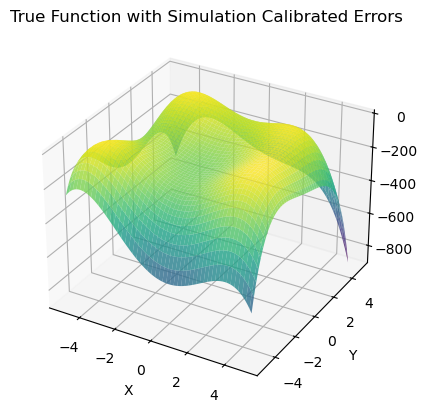

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 28069.3867
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 24641.0293
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 17349.7441
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 20558.5059
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 25362.4922
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 26364.8223
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 26355.3281
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 25650.1855
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 24023.8496
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 20628.7773
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 14347.4883
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 15356.1992
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 13080.4912
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 10147.0039
Epoch 15/500
1/1 ━━━━━━━━━━━━━━

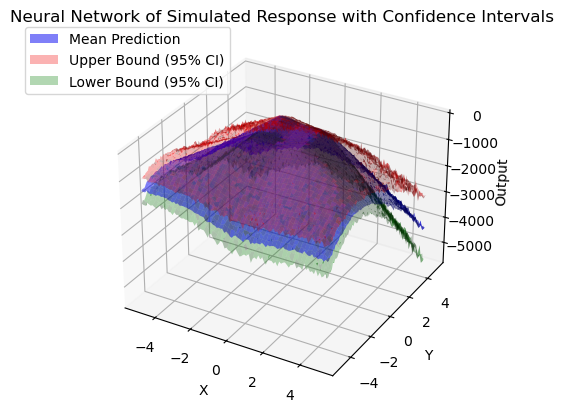

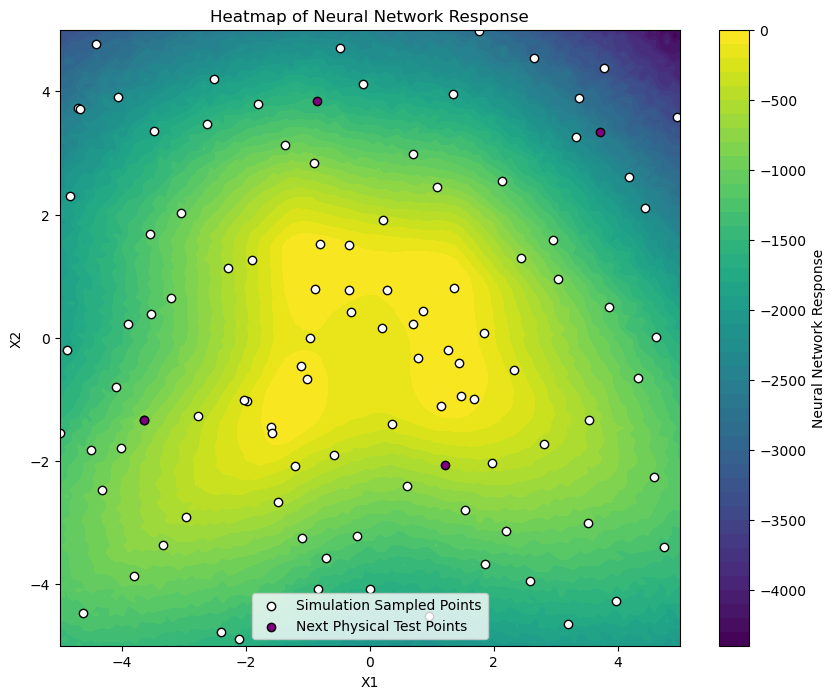

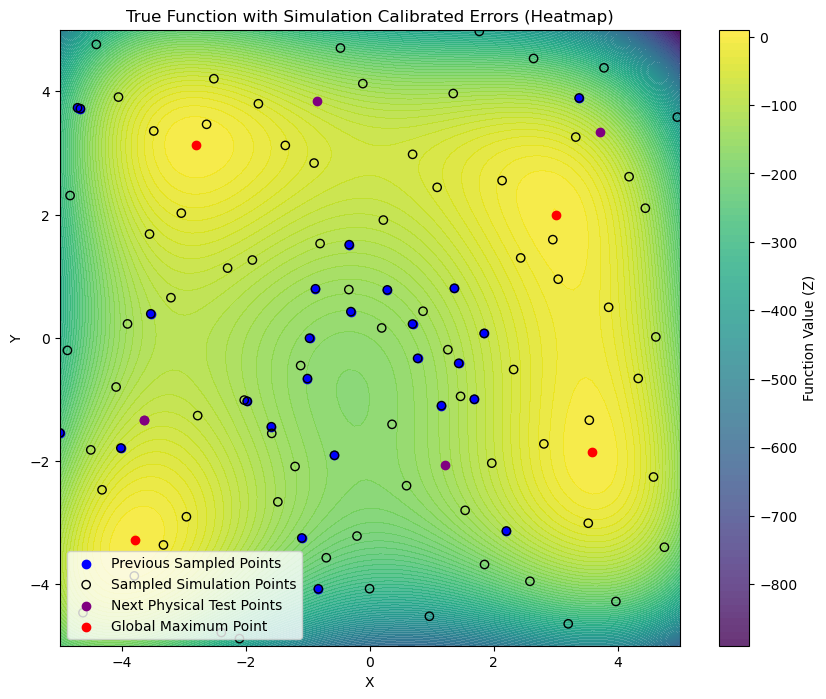

           x         y           z         a         b       sim_z      diff
0  -0.829780 -4.076614 -284.253932  3.860119 -2.954945 -284.123563 -0.130369
1   2.203245 -3.137398 -111.669530  3.860119 -2.954945 -111.870114  0.200585
2  -4.998856 -1.544393 -247.301416  3.860119 -2.954945 -246.984563 -0.316853
3  -1.976674 -1.032325 -128.722651  3.860119 -2.954945 -128.520013 -0.202638
4  -3.532441  0.388167 -111.174208  3.860119 -2.954945 -111.266281  0.092073
5  -0.972076 -0.007623 -164.820611  3.860119 -2.954945 -164.807707 -0.012904
6   0.282451  0.776517 -140.388781  3.860119 -2.954945 -140.289406 -0.099375
7  -0.875998  0.794847 -141.512763  3.860119 -2.954945 -141.568283  0.055519
8   0.689247  0.222182 -145.363744  3.860119 -2.954945 -145.367401  0.003658
9  -1.587739 -1.445021 -140.745930  3.860119 -2.954945 -140.648325 -0.097605
10 -4.713852  3.733259 -228.610101  3.860119 -2.954945 -228.996563  0.386463
11 -4.667136  3.718428 -214.870733  3.860119 -2.954945 -215.365657  0.494924

In [61]:
df = perform_iteration(df)
print(df)